In [0]:
!pip install mxnet-cu100
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
!pip3 install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [0]:
import matplotlib.pyplot as plt
import time

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 16, shuffle = False, num_workers = 2)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
for features, labels in trainloader:
    print('features.min():', features.min().item())
    print('features.max():', features.max().item())
    print('labels:', labels)
    print('labels.min():', labels.min().item())
    print('labels.max():', labels.max().item())
    break

features.min(): -1.0
features.max(): 1.0
labels: tensor([4, 4, 6, 0, 4, 8, 6, 3, 7, 9, 3, 2, 1, 1, 0, 7])
labels.min(): 0
labels.max(): 9


In [0]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = self._make_layers()
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self):
        layers = []
        in_channels = 3
        vgg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 
               512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
        for x in vgg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


model = VGG()
model.cuda()
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [0]:
losses = []

start = time.time()
model.train()
for epoch in range(10):
    batch_start = time.time()
    
    running_loss = 0.0
    
    for i, data in enumerate(trainloader):
        inputs, labels = data
        
        optimizer.zero_grad()

        outputs = model(inputs.cuda())
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()

        running_loss += loss
        
        losses.append(loss.item())
        
    print(f'Epoch: {(epoch)} | Loss: {running_loss.item() / (i + 1):.5f} | Images/Sec: {(batch_size * (i + 1)) / (time.time() - batch_start):.5f}')
        
    running_loss = 0.0

print('\nFinished Training')
print(f'Total time taken: {(time.time() - start)/60:.5f} minutes')

Epoch: 0 | Loss: 1.88198 | Images/Sec: 482.82448
Epoch: 1 | Loss: 1.47435 | Images/Sec: 471.31317
Epoch: 2 | Loss: 1.09887 | Images/Sec: 467.14587
Epoch: 3 | Loss: 0.88306 | Images/Sec: 468.30389
Epoch: 4 | Loss: 0.74330 | Images/Sec: 468.85354
Epoch: 5 | Loss: 0.62907 | Images/Sec: 469.15491
Epoch: 6 | Loss: 0.54046 | Images/Sec: 470.40302
Epoch: 7 | Loss: 0.45992 | Images/Sec: 469.42925
Epoch: 8 | Loss: 0.39484 | Images/Sec: 469.47927
Epoch: 9 | Loss: 0.33590 | Images/Sec: 469.70176

Finished Training
Total time taken: 17.73087 minutes


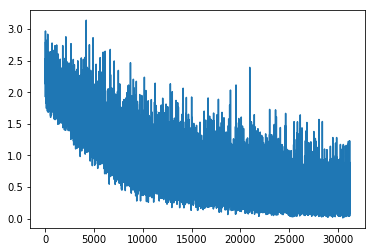

In [0]:
pytorch_losses = losses
plt.plot(pytorch_losses)
plt.show()

In [0]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print(f'Test Accuracy: {100 * correct / total}')

Test Accuracy: 82.78


In [0]:
import mxnet as mx
from mxnet import gluon, nd, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms, CIFAR10

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = CIFAR10(root = './data', train = True).transform_first(transform)
trainloader = gluon.data.DataLoader(trainset, batch_size = 16, shuffle = True, num_workers = batch_size)

testset = CIFAR10(root = './data', train = False).transform_first(transform)
testloader = gluon.data.DataLoader(testset, batch_size = 16, shuffle = True, num_workers = batch_size)

In [0]:
for features, labels in trainloader:
    print('features.min():', features.min().asscalar())
    print('features.max():', features.max().asscalar())
    
    print('labels:', labels)
    print('labels.min():', labels.min().asscalar())
    print('labels.max():', labels.max().asscalar())
    break

features.min(): -1.0
features.max(): 1.0
labels: 
[9 2 3 3 3 8 3 0 6 6 1 0 6 8 5 6]
<NDArray 16 @cpu_shared(0)>
labels.min(): 0
labels.max(): 9


In [0]:
class VGG(nn.Block):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = self._make_layers()
        self.classifier = nn.Dense(10)

    def forward(self, x):
        out = self.features(x)
        out = out.reshape((out.shape[0], -1))
        out = self.classifier(out)
        return out

    def _make_layers(self):
        layers = []
        in_channels = 3
        vgg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 
               512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
        for x in vgg:
            if x == 'M':
                layers += [nn.MaxPool2D(pool_size = 2, strides = 2)]
            else:
                layers += [nn.Conv2D(in_channels, kernel_size = 3, padding=1),
                           nn.BatchNorm(),
                           nn.Activation('relu')]
                in_channels = x
        layers += [nn.AvgPool2D(pool_size = 1, strides = 1)]
        model = nn.Sequential()
        model.add(*layers)
        return model

ctx = mx.gpu()

model = VGG()
model.initialize(ctx = ctx)
model

VGG(
  (features): Sequential(
    (0): Conv2D(None -> 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (2): Activation(relu)
    (3): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (5): Activation(relu)
    (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (7): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (9): Activation(relu)
    (10): Conv2D(None -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (12): Activation(relu)
    (13): MaxPool2D(si

In [0]:
objective = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.001})

In [0]:
losses = []

start = time.time()
for epoch in range(10):
    batch_start = time.time()
    
    running_loss = 0.0
    
    for i, data in enumerate(trainloader):
        inputs, labels = data
        
        with autograd.record():
            outputs = model(inputs.as_in_context(ctx))
            loss = objective(outputs, labels.as_in_context(ctx)).mean()
        loss.backward()
        
        trainer.step(16)

        running_loss += loss
        
        losses.append(loss.asscalar())
        
    print(f'Epoch: {(epoch)} | Loss: {running_loss.asscalar() / (i + 1):.5f} | Images/Sec: {(batch_size * (i + 1)) / (time.time() - batch_start):.5f}')
        
    running_loss = 0.0

print('\nFinished Training')
print(f'Total time taken: {(time.time() - start)/60.0:.5f} minutes')

Epoch: 0 | Loss: 1.59633 | Images/Sec: 697.00965
Epoch: 1 | Loss: 1.09746 | Images/Sec: 692.20685
Epoch: 2 | Loss: 0.87165 | Images/Sec: 686.15298
Epoch: 3 | Loss: 0.71099 | Images/Sec: 684.61231
Epoch: 4 | Loss: 0.59514 | Images/Sec: 681.85280
Epoch: 5 | Loss: 0.49947 | Images/Sec: 686.39321
Epoch: 6 | Loss: 0.41711 | Images/Sec: 685.43433
Epoch: 7 | Loss: 0.34790 | Images/Sec: 686.30278
Epoch: 8 | Loss: 0.28938 | Images/Sec: 689.74632
Epoch: 9 | Loss: 0.24199 | Images/Sec: 688.23215

Finished Training
Total time taken: 12.11654 minutes


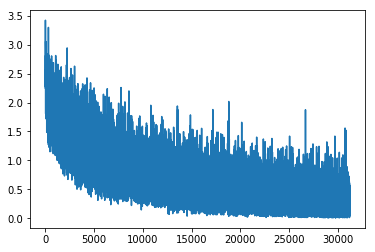

In [0]:
mxnet_losses = losses
plt.plot(mxnet_losses)
plt.show()

In [0]:
metric = mx.metric.Accuracy()
metric.reset()
for inputs, labels in testloader:
    outputs = model(inputs.as_in_context(ctx))
    metric.update(labels.as_in_context(ctx), outputs)

print(f'Test Accuracy: {metric.get()[1]}')

Test Accuracy: 0.827


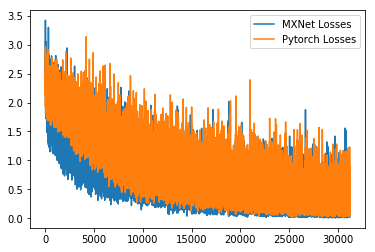

In [0]:
plt.plot(mxnet_losses, label = 'MXNet Losses')
plt.plot(pytorch_losses, label = 'Pytorch Losses')
plt.legend()
plt.show()